In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from cs109.model import density_last
from cs109.model import proximity_last
from cs109.model import martingale
from cs109.model import p_value
from cs109.model import KNNAnomalyDetector

%matplotlib inline

## The Method

In this project we apply the idea of testing exchangeability online (Vovk et al., 2003) using a martingale framework to detect concept changes in time-varying data streams.

In brief, the anomaly detection happens by performing the following steps:

1. A data point from the incoming stream is observed.
2. A strangeness measure is calculated.
3. A p-value is calculated (H0 is no concept change).
4. A randomized power martingale is constructed.
5. A test is performed using the martingale value.

This document explains our implementation and hopefully builds the reader's intuition on how to apply it.

## Strangeness Measure

We wanted our strangeness measure to: 

-	be able to handle multi-dimensional time series  
-	be able to handle unlabeled data
-	be simple and flexible 

We decided to implement two methods, both based on the well-known k-nearest neighbors algorithm:

1. Proximity based - maximum distance in the neighborhood.
2. Density based - relative density in the neighborhood.

The maximum distance in the neighborhood measure is straightforward: given a point and a neighborhood of size k, we find a distance to the furthest point away in the neighborhood.

The relative density is a bit more involved. Given a neighborhood of size k, we measure density as an inverse of the sum of all distances between the point and its neighbors. The relative density is calculated by dividing the point density by sum of densities for all the k-nearest neighbors.

## P-Value

is calculated as:

$$p = \frac{ count(i:a_{i} > a_{n}) + \theta*count(i:a_{i} = a_{n}) }{n}$$

where $a_{i}$ is the strangeness measure for $i-th$ observation and $\theta$ is randomly chosen from $[0, 1]$

## Randomized Power Martingale

is calculated as:

$$M_{n} = \epsilon p_{n}^{(\epsilon - 1)} M_{n - 1}$$

where $\epsilon$ is a float value from $[0, 1]$

## Implementation Detail

Our class is called KNNAnomalyDetector and it accepts the following parameters:

    threshold - float, optional (default value 2.0)
        an anomaly is reported when the threshold is breached
    epsilon - float, optional (default value 0.92)
        Value from 0.0 to 1.0, used in the martingale calculation
    n_neighbors - int, optional (default value 3)
        The neighborhood size
    metric - string, optional (default value 'euclidean')
        The distance metric used to calculate the k-neighbors for each sample point
    method - string , 'density' or 'proximity,' default value 'density'
        Method of calculating the strangeness function. 
        When 'density' the strangeness is calculated as density around the point 
        divided by total density around the neighborhood
        When 'proximity' the strangeness is calculated as maximum distance in the the neighborhood
    anomaly - string , 'level' or 'change,' default value 'level'
        Method of using the threshold
        When 'level,' the martingale value is compared with the threshold
        When 'change,' the change in martingale value is compared with the threshold


## Building Intuition

Below we present two generated datasets showing a concept change and analyze the behaviour of chosen strangeness measure and the method as a whole.

### Sample 1: consists of a cluster of 100 points of stretched Gaussian data and a straight line of 10 points going away from the cluster, representing a slow change in value

In [2]:
def gen_data1(mult = 1.0):
    C = np.array([[1., 3.7], [1.9, 2.7]])
    d1 = np.dot(np.random.randn(90, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.column_stack((np.linspace(20., 30.*mult, num = 10), np.linspace(20., 10.*mult, num = 10)))
    ))
    return d1, d2

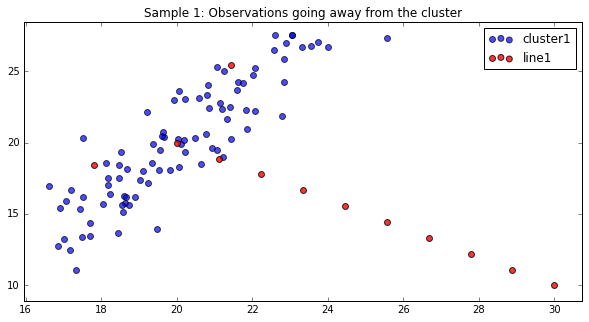

In [3]:
cluster1, line1 = gen_data1()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster1[:, 0], cluster1[:, 1], c='blue', alpha=0.7, label='cluster1', s=35)
ax.scatter(line1[:, 0], line1[:, 1], c='red', alpha=0.8, label='line1', marker='o',s=35)
ax.set_title('Sample 1: Observations going away from the cluster')
ax.legend(loc='best')
a = ax.axis('tight')

### Sample 2: consists of a cluster of 30 points (less dense) of stretched Gaussian data and another cluster of 20 points building outside the main cluster, representing a sudden change in value

In [4]:
def gen_data2(mult = 1.0):
    C = np.array([[1.5, 3.7], [2.5, 2.7]])
    d1 = np.dot(np.random.randn(30, 2), C) + np.array([20, 20])
    d2 = np.concatenate((
            np.dot(np.random.randn(2, 2), C) + np.array([20, 20]),
            np.dot(np.random.randn(20, 2), np.array([[.7, 0.2], [.5, .8]])) + np.array([35*mult, 5*mult])
        ))
    return d1, d2

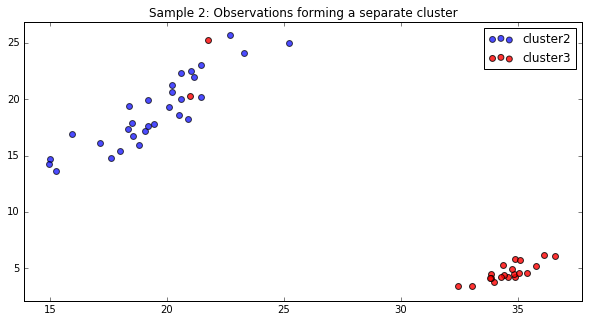

In [5]:
cluster2, cluster3 = gen_data2()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(cluster2[:, 0], cluster2[:, 1], c='blue', alpha=0.7, s=35, label='cluster2')
ax.scatter(cluster3[:, 0], cluster3[:, 1], c='red', marker='o', alpha=0.8, s=35, label='cluster3')
ax.set_title('Sample 2: Observations forming a separate cluster')
ax.legend(loc='best')
a = ax.axis('tight')

## Strangeness Measure

We start building our intuition by observing how the strangeness measures change in the datasets above. We simulate on-line mode by 'observing' the data points in the same order they were generated and calculate relative density or proximity strangeness measure for the last point.

## Strangeness Measure by the Metrics

Our strangeness measures can use the following distance metrics:  

- 'euclidean' EuclideanDistance:  $sqrt(sum((x - y)^2))$
- 'manhattan' ManhattanDistance:  $sum(|x - y|)$
- 'chebyshev' ChebyshevDistance   $max(|x - y|)$

Let's see how the metric choice impacts the strangeness measure values.

In [6]:
metrics = ['euclidean', 'manhattan', 'chebyshev']

### Sample 1: Observations Moving Away / Slow Change

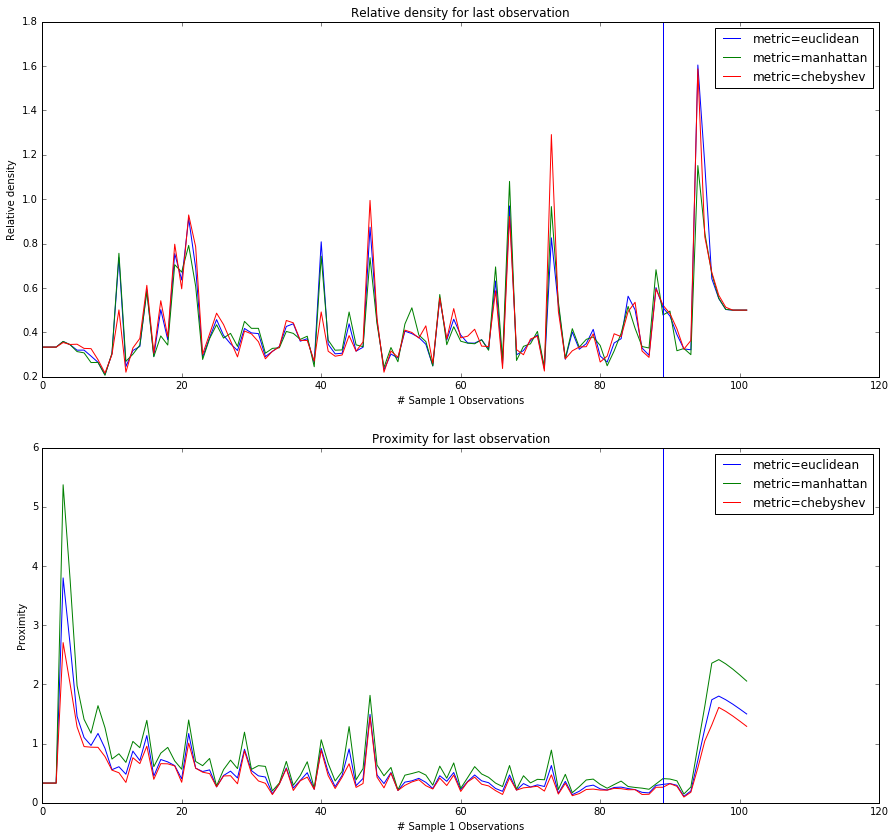

In [7]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for metric in metrics:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster1, line1)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = 3, metric = metric))
        P.append(proximity_last(X, n_neighbors = 3, metric = metric))
    ax1.plot(D, label = 'metric=' + metric)
    ax2.plot(P, label = 'metric=' + metric)
    
ax1.axvline(x = cluster1.shape[0] - 1)
ax1.set_xlabel('# Sample 1 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster1.shape[0] - 1)
ax2.set_xlabel('# Sample 1 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')

First of all, there is a clear spike in the strangeness measures during the initial cluster build up. Whether it is going to affect the model performance is not clear at this point, but we definitely should note that fact.

In both cases, the strangeness measure changes with the underlying concept change (which is marked by the vertical blue line). It looks like the proximity measure is a bit more sensitive in this case.

There are differences in the measures produced by using different distance metrics, so we should investigate the impact further by evaluating the model performance using real multidimensional data.

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

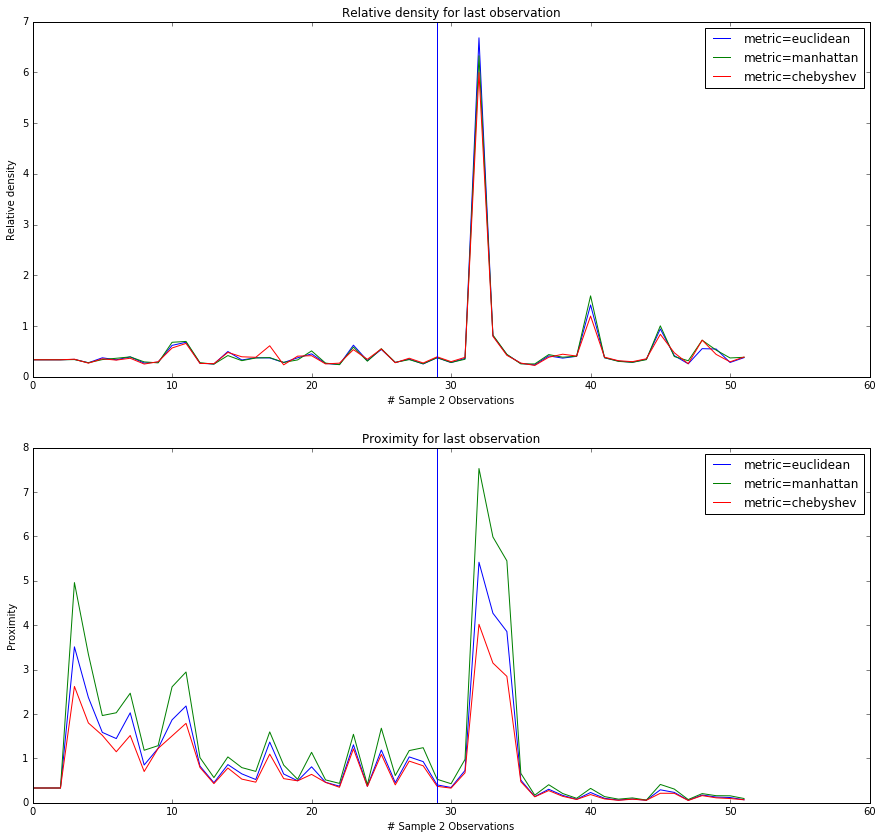

In [8]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for metric in metrics:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster2, cluster3)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = 3, metric = metric))
        P.append(proximity_last(X, n_neighbors = 3, metric = metric))
    ax1.plot(D, label = 'metric=' + metric)
    ax2.plot(P, label = 'metric=' + metric)
    
ax1.axvline(x = cluster2.shape[0] - 1)
ax1.set_xlabel('# Sample 2 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster2.shape[0] - 1)
ax2.set_xlabel('# Sample 2 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')

Both metrics performed very well in this case. They clearly produced larger metrics for 'stranger' observations.

## Strangeness Measure by the Neighborhood Size

We next investigated how the neighborhood size impacts the strangeness measures.

In [9]:
neighborhoods = [1, 2, 3, 4, 5, 6]

### Sample 1: Observations Moving Away / Slow Change

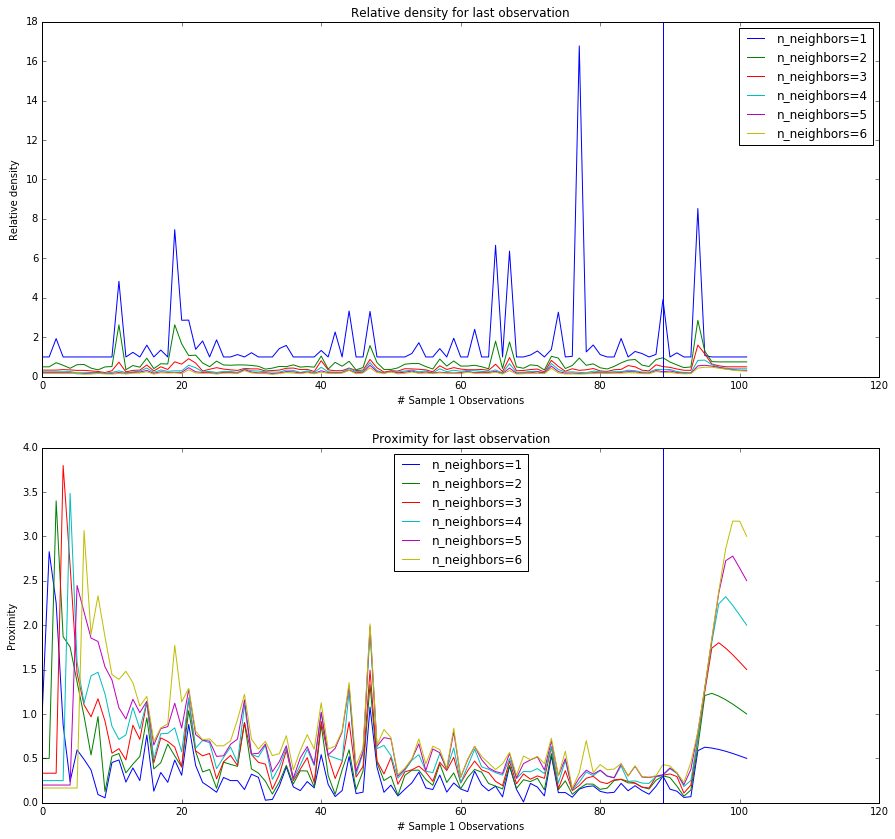

In [10]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for n_neighbors in neighborhoods:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster1, line1)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
        P.append(proximity_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
    ax1.plot(D, label = 'n_neighbors=' + str(n_neighbors))
    ax2.plot(P, label = 'n_neighbors=' + str(n_neighbors))
    
ax1.axvline(x = cluster1.shape[0] - 1)
ax1.set_xlabel('# Sample 1 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster1.shape[0] - 1)
ax2.set_xlabel('# Sample 1 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')

With n_neighbors = 1, the relative density measure would not be able to detect observations slowly moving away from the cluster. It looks like we should use a 'conventional' value for n_neighbors (between 3 or 5 in most cases).

The proximity measure did well in this scenario with all of the neighborhood sizes. It also looks like larger neighborhood sizes allow the measure to stay 'strange' for longer time periods (that is why it did well here).

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

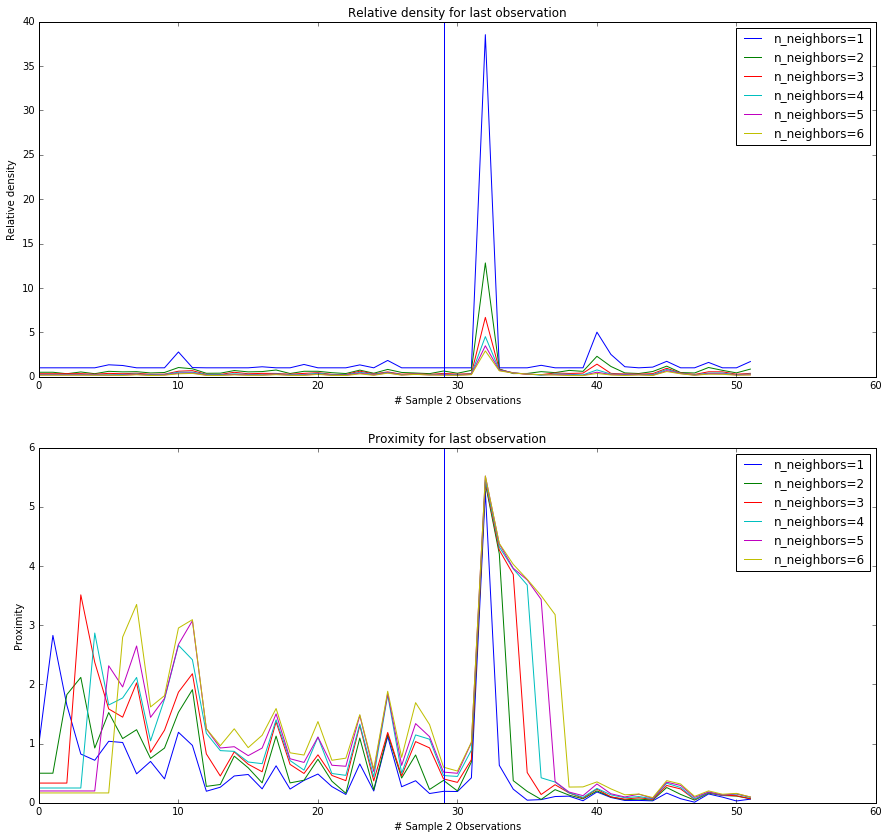

In [11]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for n_neighbors in neighborhoods:
    observations = []
    D = []
    P = []
    for x in np.concatenate((cluster2, cluster3)):
        observations.append(x)
        X = StandardScaler().fit_transform(np.array(observations))
        D.append(density_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
        P.append(proximity_last(X, n_neighbors = n_neighbors, metric = 'euclidean'))
    ax1.plot(D, label = 'n_neighbors=' + str(n_neighbors))
    ax2.plot(P, label = 'n_neighbors=' + str(n_neighbors))
    
ax1.axvline(x = cluster2.shape[0] - 1)
ax1.set_xlabel('# Sample 2 Observations')
ax1.set_ylabel('Relative density')
ax1.set_title('Relative density for last observation')
ax1.legend(loc='best')

ax2.axvline(x = cluster2.shape[0] - 1)
ax2.set_xlabel('# Sample 2 Observations')
ax2.set_ylabel('Proximity')
ax2.set_title('Proximity for last observation')
ax2.legend(loc='best')

Again, the separate cluster forming was easily detected by both measures. The relative density appears a bit more stable and tolerant to initial cluster building, but the proximity measure could potentially produce large values for longer time periods, which could be beneficial as we would like our martingale to have enough time for confidence building.

## Martingale and the Epsilon Value

The initial martingale value is $M_{0} = 1.0$ and with every new observation we calculate the martingale value as $M_{n} = \epsilon p_{n}^{(\epsilon - 1)} M_{n - 1}$, where $p$ is the p-value.

Changing the epsilon value changes how quickly the martingale rises/falls in the presence of very small or large p-values.

Let's simulate a stream of p-values perhaps indicating some change in the middle of the stream and observe changes in the martingale value for different epsilon values.

In [12]:
linestyles = ['h', '-', '--', 'o', 'v']
epsilons = np.linspace(0.15, 0.95, num = 9)

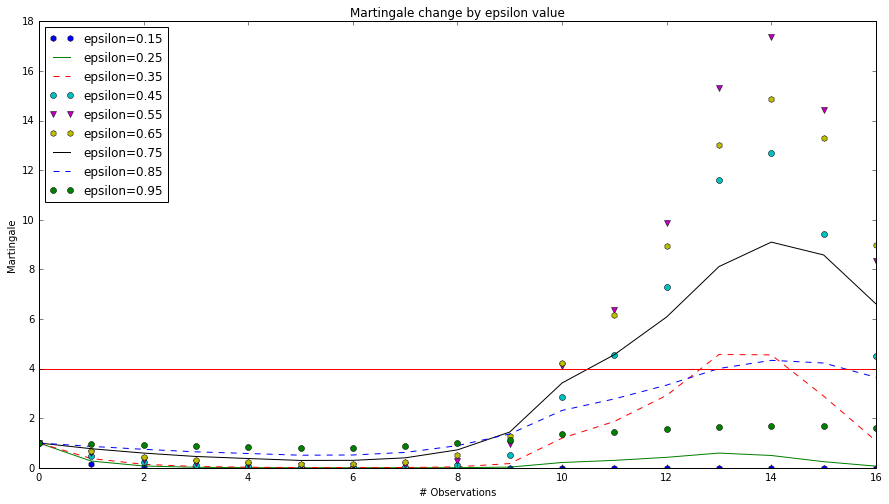

In [13]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

for i, epsilon in enumerate(epsilons):
    M = [1.0]
    for p in np.array([0.9, 0.9, 0.9, 0.7, 0.8, 0.3, 0.1, 0.03, 0.02, 0.01, 0.1, 0.1, 0.1, 0.2, 0.4, 0.9]):
        M.append(martingale(M[len(M)-1], p, epsilon))
    ax.plot(M, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))
ax.axhline(y=4.0, color='r', linestyle='-')
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.legend(loc='best')
ax.set_title('Martingale change by epsilon value')

The martingale value can get very small if there are no changes in the stream for some time. 

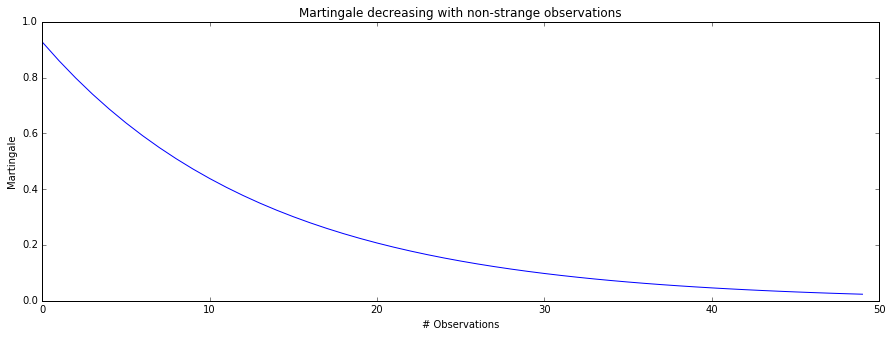

In [14]:
M = []
epsilon = 0.92
m = 1.0
for p in np.repeat(0.9, 50):
    m = martingale(m, p, epsilon)
    M.append(m)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(M)
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.set_title('Martingale decreasing with non-strange observations')

We need to know how quick it can grow when 'strange' observations start appearing.

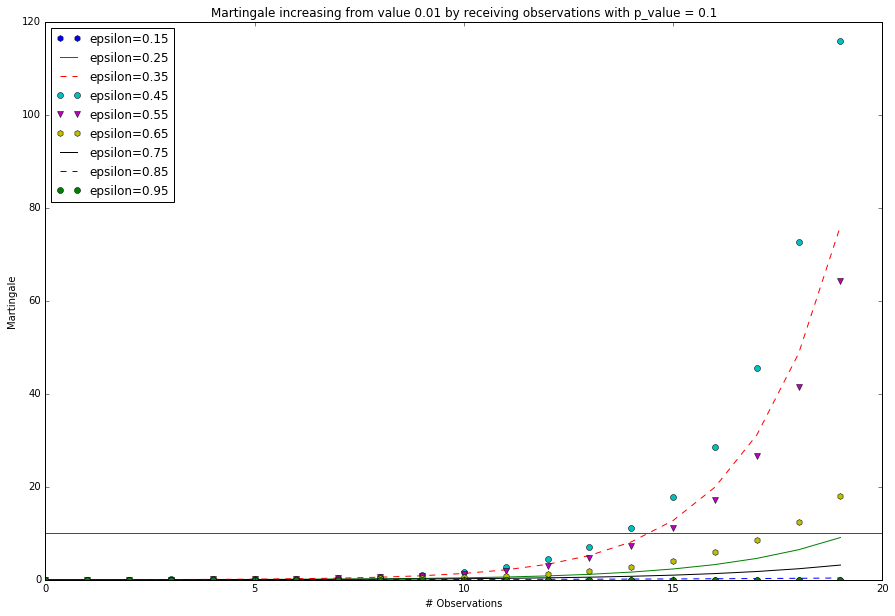

In [15]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

m_initial = 0.01
p_observed = 0.1

for i, epsilon in enumerate(epsilons):
    M = []
    m = m_initial
    for p in np.repeat(p_observed, 20):
        m = martingale(m, p, epsilon)
        M.append(m)
    ax.plot(M, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))

ax.axhline(y=10.0, color='r', linestyle='-')
ax.set_xlabel('# Observations')
ax.set_ylabel('Martingale')
ax.set_title(
    'Martingale increasing from value {} by receiving observations with p_value = {}'.format(m_initial, p_observed))
ax.legend(loc='best')    

A martingale calculated with epsilon = 0.45 first breaches the threshold at 10.0 on the 14th step. We should probably look at lower thresholds for the relative density measure as it is unlikely to produce large values for that long. For the proximity measure, it might be okay to use the smaller epsilon values.

In [16]:
def observations_to_breach(m_initial, p_observed, epsilon, threshold):
    m = m_initial
    n_recover = 0
    for p in np.repeat(p_observed, 1000):
        n_recover += 1
        m = martingale(m, p, epsilon)
        if m > threshold:
            break
    return n_recover

It is obvious the martingale needs to build a confidence level by receiving quite a few small p-values before the threshold is reached. That might not work very well in conjunction with KNN-based metrics as the strangeness measure might go down as soon as the new neighborhood is built.

In order to have a better picture of how the martingale value is changing, let's look at all influencing factors:

- initial martingale value
- p-values observed
- number of steps to breach a threshold
- different epsilon parameters

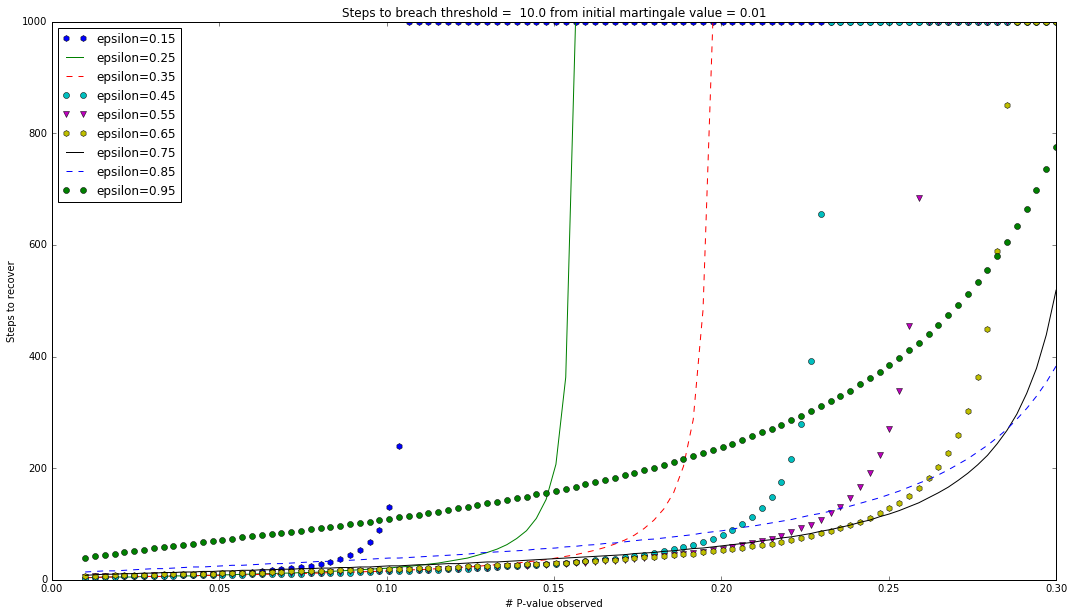

In [17]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(1, 1, 1)

threshold = 10.0
m_initial = 0.01

pvalues = np.linspace(0.01, 0.3, num = 100)
for i, epsilon in enumerate(epsilons):
    results = []
    for p_observed in pvalues:
        results.append(observations_to_breach(m_initial, p_observed, epsilon, threshold))
    ax.plot(pvalues, results, linestyles[i%len(linestyles)], label = 'epsilon=' + str(epsilon))
    
ax.set_title('Steps to breach threshold =  {} from initial martingale value = {}'.format(threshold, m_initial))
ax.set_xlabel('# P-value observed')
ax.set_ylabel('Steps to recover')
ax.legend(loc='best')    

From the chart above, we could see that small epsilon values should not be used for stable streams. A martingale calculated with epsilon = 0.15 would need more then 1000 observations with p-values of 0.1 to breach a threshold of 10.

## Model with Default Values
- the neighborhood consists of 3 neighbors
- density calculated relatively to total density in the neighborhood
- euclidean distance is used
- epsilon = 0.92

In [18]:
def plot_results(data1, data2, r, title):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(data1[:, 0], data1[:, 1], c='blue',alpha=0.7, label='data1', s=30)
    ax1.scatter(data2[:, 0], data2[:, 1], c='red', alpha=0.8, label='data2', marker='o',s=30)
    ax1.axis('tight')
    ax1.legend(loc='best')
    ax1.set_title(title + ': Raw Data')

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(r[:, 0], color='magenta',linewidth=1.2)
    ax2.set_title(title + ': Strangeness')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(r[:, 1], color='green', linewidth=1.2)
    ax3.set_title(title + ': P-value')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.plot(r[:, 2], color='navy', linewidth=1.2)
    ax3.set_title(title + ': Martingale')

In [19]:
def perform_experiment(model, data1, data2, title):
    for x in data1:
        model.observe(x)
    results = []
    for x in data2:
        results.append(model.observe(x))
    r = np.array(results)
    plot_results(data1, data2, r, title)

### Sample 1: Observations Moving Away / Slow Change 

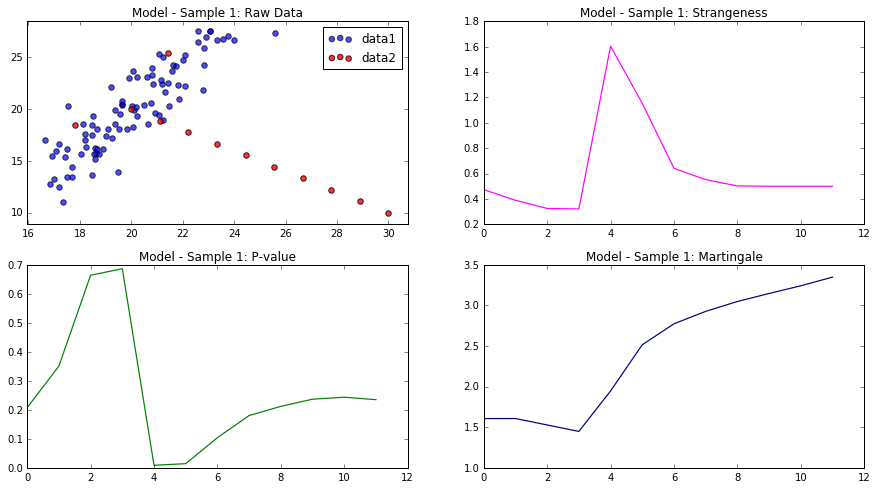

In [20]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster1, line1,'Model - Sample 1')

In this experiment, we observe how the strangeness measure (relative density) goes up, the p-value goes down, and the martingale builds confidence in the underlying change by growing up.

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

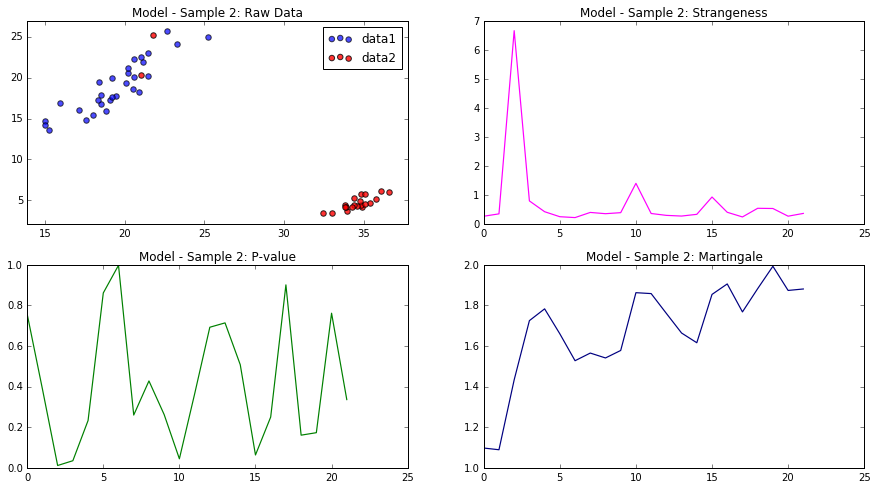

In [21]:
model = KNNAnomalyDetector()
perform_experiment(model, cluster2, cluster3, 'Model - Sample 2')

This experiment highlights a possible weakness in our model: a small neighborhood size could prevent us from detecting underlying changes in the data stream. In this case, as soon as the number of observation in the separate cluster reached the neighborhood size, the relative density went down and the martingale did not have enough time to build the confidence.

## Neighborhood Size

Let's see how our method behaves with the different neighborhood sizes.

### Sample 1: Observations Moving Away / Slow Change

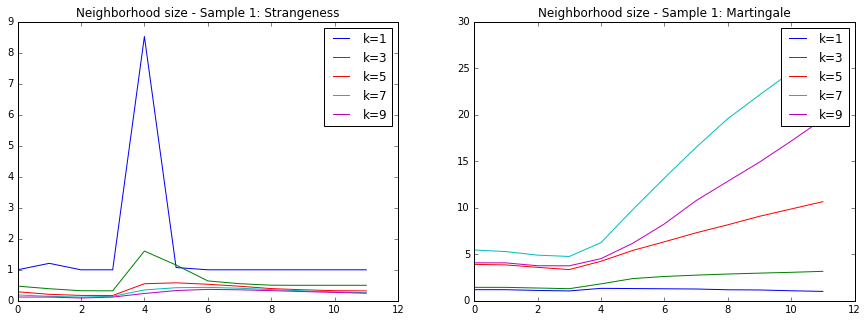

In [22]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Neighborhood size - Sample 1: Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Neighborhood size - Sample 1: Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster1:
        detector.observe(x)
    results = []
    for x in line1:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

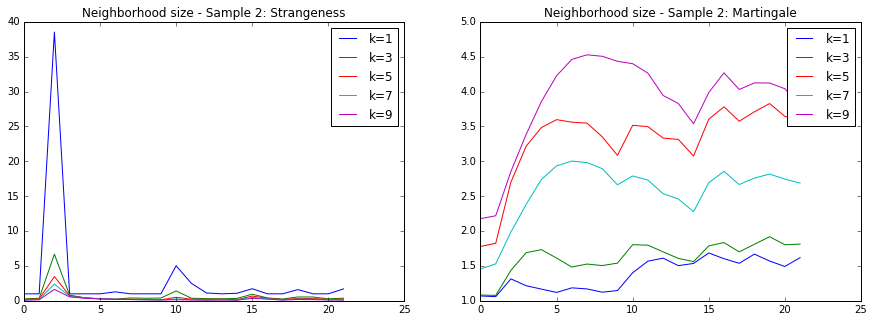

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Neighborhood size - Sample 2: Strangeness')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Neighborhood size - Sample 2: Martingale')

for n_neighbors in [1, 3, 5, 7, 9]:
    detector = KNNAnomalyDetector(n_neighbors = n_neighbors)
    for x in cluster2:
        detector.observe(x)
    results = []
    for x in cluster3:
        results.append(detector.observe(x))
    r = np.array(results)
    ax1.plot(r[:, 0], label = 'k=' + str(n_neighbors))
    ax2.plot(r[:, 2], label = 'k=' + str(n_neighbors))
    
ax1.legend()
ax2.legend()

Conclusions:
- Our default martingale calculation is not very sensitive to the sharp but short lived changes of the strangeness measure
- Changes in the neighborhood size might have a lot of influence on the relative density calculation and the martingale value

On the chart above, we see how the epsilon value plays a role in the martingale calculation. The concept change happens at step five and all the martingales reach maximum value around step 14 (at different levels). If we set the threshold at level 4.0, then a martingale with epsilon = 0.65 would detect the change at step 10 while martingale with epsilon 0.35 would detect the change at step 14. It looks like too small or too big an epsilon value might not be very sensitive to the changes, and the best performing epsilon values in this case are in 0.75 - 0.95 range.

## Tuning the Defaut Model with Epsilon and the Neighborhood Size

### Sample 1: Observations Moving Away / Slow Change

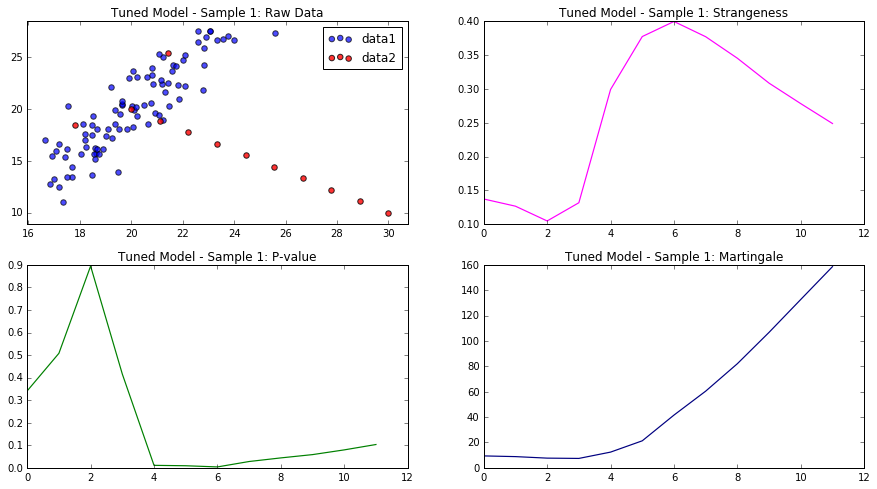

In [24]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster1, line1, 'Tuned Model - Sample 1')

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

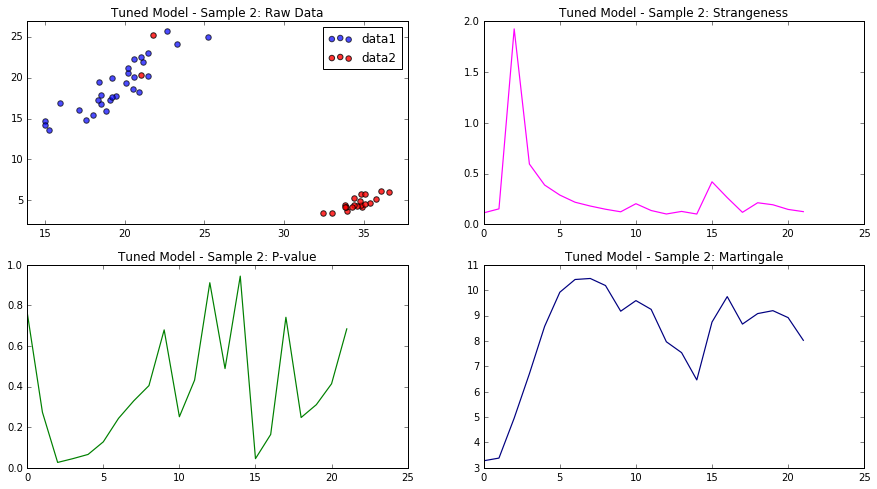

In [25]:
model = KNNAnomalyDetector(n_neighbors = 8, epsilon = 0.85)
perform_experiment(model, cluster2, cluster3, 'Tuned Model - Sample 2')

We already have better models detecting both anomalies.

## Different Distance Metrics

### Manhattan Distance

### Sample 1: Observations Moving Away / Slow Change

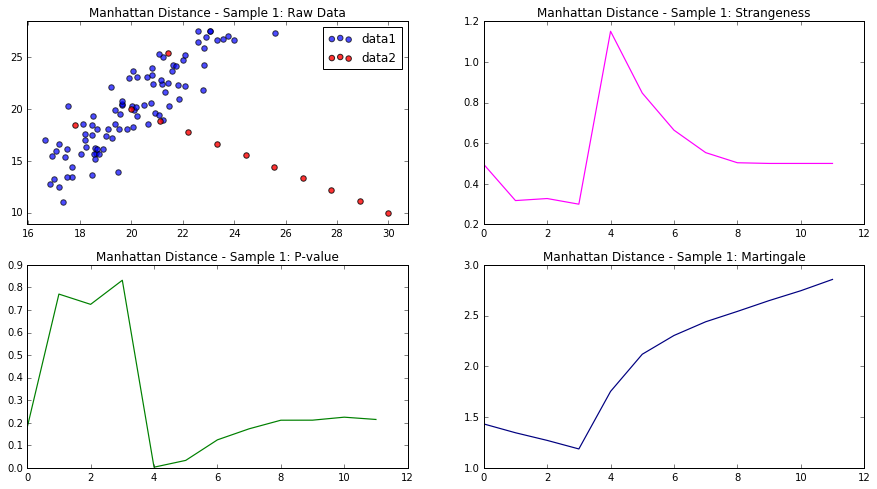

In [26]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster1, line1, 'Manhattan Distance - Sample 1')

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

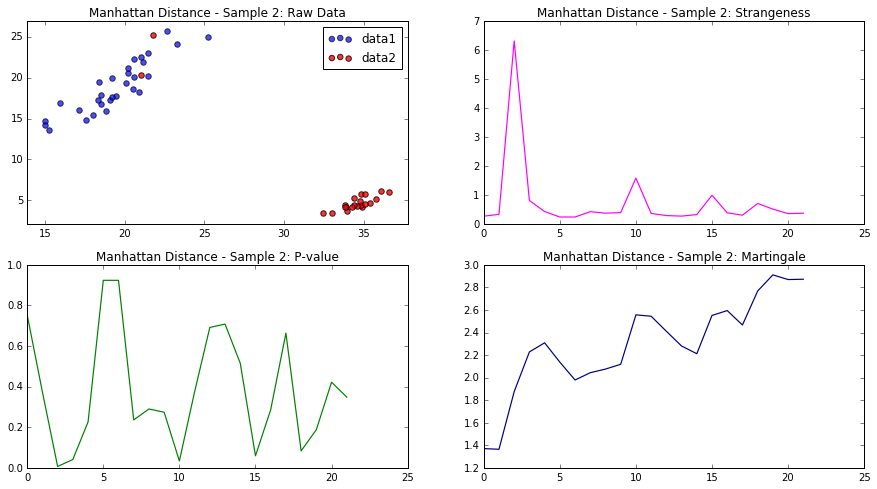

In [27]:
model = KNNAnomalyDetector(metric='manhattan')
perform_experiment(model, cluster2, cluster3, 'Manhattan Distance - Sample 2')

### Chebyshev Distance

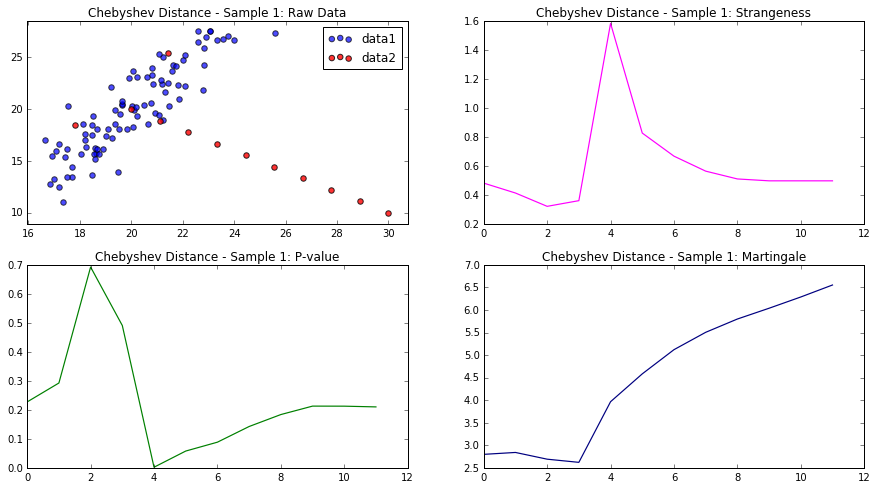

In [28]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster1, line1, 'Chebyshev Distance - Sample 1')

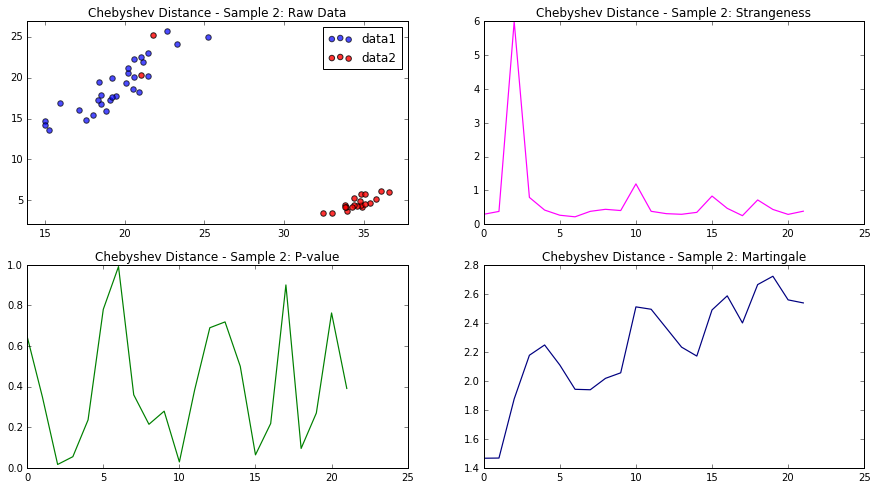

In [29]:
model = KNNAnomalyDetector(metric='chebyshev')
perform_experiment(model, cluster2, cluster3, 'Chebyshev Distance - Sample 2')

In our experiment, it is not so obvious which distance should be used and why, but when we work with high dimensional data, we should try all of them.

### Density Versus Proximity

### Sample 1: Observations Moving Away / Slow Change

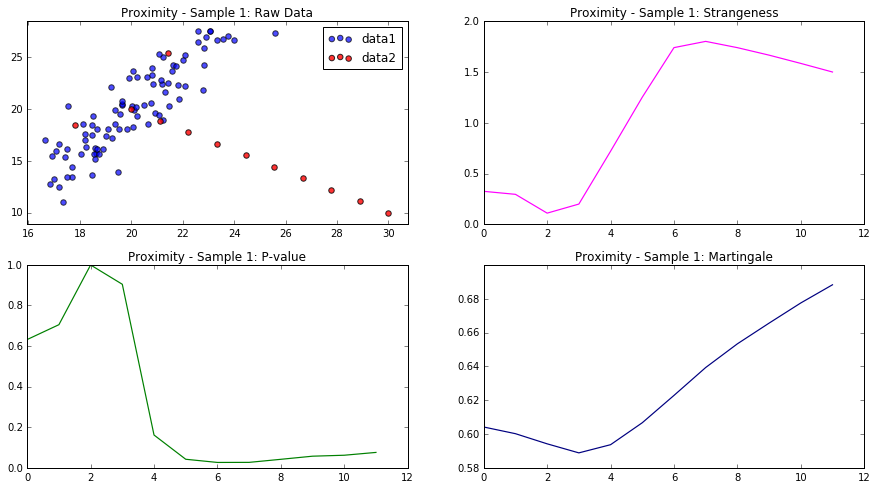

In [30]:
model = KNNAnomalyDetector(method='proximity', epsilon = 0.99)
perform_experiment(model, cluster1, line1, 'Proximity - Sample 1')

### Sample 2: Observations Forming a Separate Cluster / Rapid Change

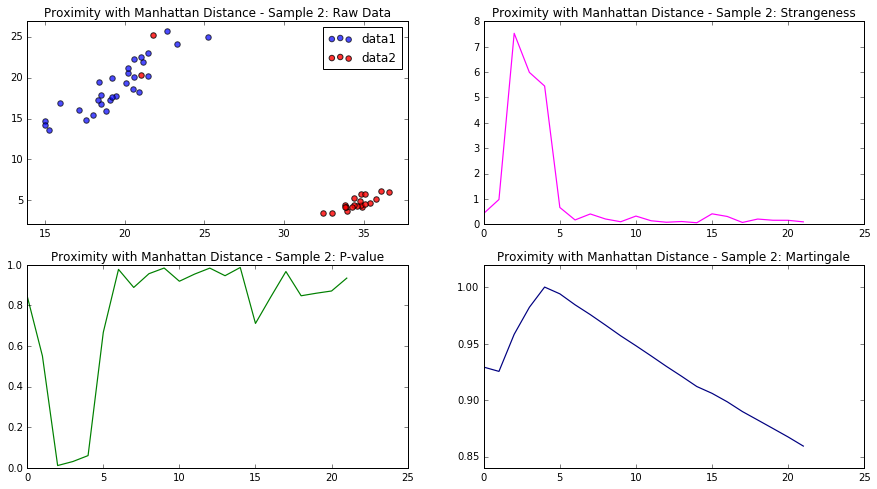

In [31]:
model = KNNAnomalyDetector(method='proximity', metric='manhattan', epsilon = 0.99)
perform_experiment(model, cluster2, cluster3, 'Proximity with Manhattan Distance - Sample 2')

The proximity strangeness measure seems to be the weaker option. More investigation should be done to understand where it is applicable.

## Detecting Mutiple Changes

Because of the way we calculate the p-values, we will not be able to detect some sequence of the concept changes. For example, if our system changes from state A to state B, we might be able to detect the change. But the change from B back to A will be unnoticeable because the values associated with state A had been observed before. We might be able to solve this problem by introducing some kind of expiration policy on the historical values.